In [1]:
#Install necessary packages: 
#!pip install tensorflow==2.1
#!pip install tensorflow-quantum

In [ ]:
#imports
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
from google.colab import drive
drive.mount('path')

In [ ]:
folder_benign_train = '.../data/train/benign'
folder_malignant_train = '.../data/train/malignant'

folder_benign_test = '.../data/test/benign'
folder_malignant_test = '.../data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in tqdm(os.listdir(folder_benign_train))]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in tqdm(os.listdir(folder_malignant_train))]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in tqdm(os.listdir(folder_benign_test))]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in tqdm(os.listdir(folder_malignant_test))]
X_malignant_test = np.array(ims_malignant, dtype='uint8')



100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


In [ ]:
#create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

#merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0) #training data
y_train = np.concatenate((y_benign, y_malignant), axis = 0) #training labels

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0) #test data
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0) #test labels

In [ ]:
#shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

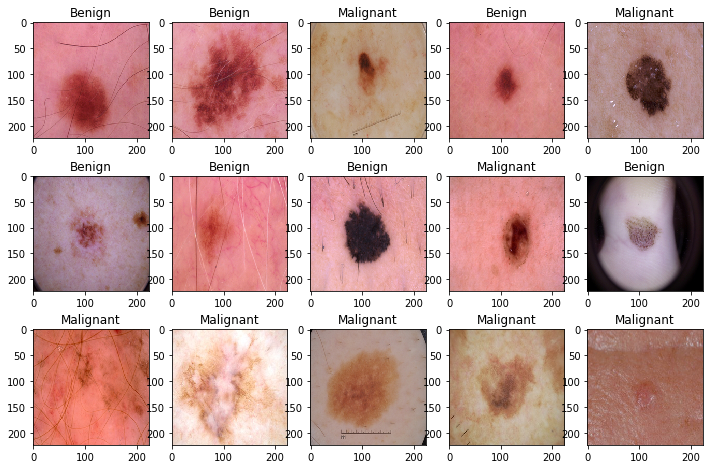

In [ ]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()


In [ ]:
#categorical
#y_train = to_categorical(y_train, num_classes= 2)
#y_test = to_categorical(y_test, num_classes= 2)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train)

y_train = enc.transform(y_train).toarray()
y_test = enc.transform(y_test).toarray()


In [ ]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.


In [ ]:
import cv2 

#grayscaled & resized data
gray_X_train = []
gray_X_test = []


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

for image in X_train:
  img = rgb2gray(image)
  gray_X_train.append(cv2.resize(img, (4,4)))

for image in X_test:
  img = rgb2gray(image)
  gray_X_test.append(cv2.resize(img, (4,4)))

print(gray_X_train[0])

[[0.00290524 0.00299289 0.00297664 0.00291146]
 [0.00280435 0.00210582 0.00288184 0.00295011]
 [0.0028591  0.00202475 0.00294808 0.00295273]
 [0.00287945 0.00290387 0.00299741 0.00299282]]


In [ ]:


def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


In [ ]:
x_train_circ = [convert_to_circuit(x) for x in gray_X_train]
x_test_circ = [convert_to_circuit(x) for x in gray_X_test]

In [ ]:
#convert cirq circuits to tensors for tfq:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
#QNN Implementation: classification is based on the expectation of the readout qubit --> use 2 qubit gates with the readout qubit always acted on 

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

#2 layered model that matches the data-circuit size 
#preparation and readout operations 

def create_quantum_model():
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

model_circuit, model_readout = create_quantum_model()

In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

#hinge_accuracy = handles [-1, 1] as y_true labels argument
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
EPOCHS = 3
BATCH_SIZE = 8

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=8,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)